In [1]:
import pandas as pd
import numpy as np
from glob import glob
import ahocorasick
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
def get_info(files):
    peps_tissues = {}
    for f in files:
        tissue_peps = [x.strip() for x in open(f, 'r').readlines()]
    
        for tissue_pep in tissue_peps[1::]:
            tissue = tissue_pep.split('\t')[0].lower()
            peps  = tissue_pep.split('\t')[1].upper()
            for pep in peps.split(','):
                try:
                    peps_tissues[pep].add(tissue)
                except KeyError:
                    peps_tissues[pep] = set([tissue])
    return peps_tissues

peps_tissues = get_info(['count-tables/PXD016999-tissue_peps.tsv', 'count-tables/PXD010154-tissue_peps.tsv'])
peps_samples = get_info(['count-tables/sample_peps.tsv'])
print(len(peps_samples))
print(len(peps_tissues))



4991
4991


In [60]:
peps_file = 'blast_canonical-count-tables/1-2mismatches_peptides_match_info/peptide_gene_symbol_protein_matching_info_add.tsv'
peps_header = [x.strip().split('\t') for x in open(peps_file, 'r').readlines()][0]
peps_all = [x.strip().split('\t') for x in open(peps_file, 'r').readlines()][1::]

pep_var_info = {}
for i, pep_line in enumerate(peps_all):
    pep_seq = pep_line[peps_header.index('peptide')]
    prot_id = pep_line[peps_header.index('canonical_protein_ID')]
    prot_seq = pep_line[peps_header.index('canonical_protein_seq')]
    
    gene_symbol = pep_line[peps_header.index('gene_symbol')]
    variant_info = pep_line[peps_header.index('mismatch_info')]
    
    var = re.sub('[0-9]+', '', variant_info) 
    
    var_pos = re.sub('[A-Z]', '', variant_info).split('>')[0].split('-')[0]
    
    #to differentiate between same variants at different locations of the protein add an additional AA.
    try:
        var = prot_seq[int(var_pos)-2] + '#' + var + '#' + prot_seq[int(var_pos)] 
        if gene_symbol=='CHGB' and pep_seq == 'GQPQSQEESEEGEEDATSEVDK':
            print(var)
    except IndexError:
        pass
    
    #print('found {} in {} {} {}'.format(pep_seq, prot_id, var, var_pos))
    
    samples = pep_line[peps_header.index('GCA_protein_seq')].split('[')[3].split(']')[0].replace(" ", "").replace("'", "").split(",")
    tissues = set()
    try:
        tissues = set(peps_tissues[pep_seq])
    except KeyError:
        pass
    
    try:
        pep_var_info[pep_seq][0].append(var)
        pep_var_info[pep_seq][1].append(variant_info)
        pep_var_info[pep_seq][2].union(samples)
        pep_var_info[pep_seq][3].union(tissues)
        pep_var_info[pep_seq][3].union(prot_id.split(','))
        pep_var_info[pep_seq][3].union(set(gene_symbol.split(',')))
    except KeyError:
        pep_var_info[pep_seq] = [[var], [variant_info], set(samples), set(tissues), set(prot_id.split(',')), set(gene_symbol.split(','))]
print(len(pep_var_info))



P#R>Q#S
P#R>Q#S
4766


In [61]:
print(pep_var_info['GQPQSQEESEEGEEDATSEVDK'])

[['P#R>Q#S', 'P#R>Q#S'], ['258R>Q', '238R>Q'], {'GCA_018503525.1', 'GCA_018470425.1'}, {'adrenal gland', 'heart left ventricle', 'minor salivary gland', 'skeletal muscle tissue', 'sigmoid colon', 'esophagus mucosa', 'thyroid gland', 'pituitary gland', 'vagina', 'pancreas', 'lung', 'transverse colon', 'heart atrial appendage'}, {'ENSP00000368244.4'}, {'CHGB'}]


In [62]:
#identify peptides that are substrings of each other
pep_var_info_sorted = {}
for k in sorted(pep_var_info, key=len, reverse=True):
    pep_var_info_sorted[k] = pep_var_info[k]

inserted_pairs = {}
matching_peps = {}
for pep_seq in pep_var_info_sorted.keys():
    p1 = pep_seq
    for s in matching_peps.keys():
        if pep_seq in s:# and pep_var_info_sorted[pep_seq][0]==pep_var_info_sorted[s][0]:
            p1 = s
            break
    
    if p1==pep_seq:
        for pep in pep_var_info_sorted.keys():
            if ((pep_seq in pep) and pep_var_info_sorted[pep_seq][0]==pep_var_info_sorted[pep][0]):
                p1 = pep
                break
    
    try:
        matching_peps[p1].append(pep_seq)
    except KeyError:
        matching_peps[p1] = [pep_seq]

print(len(matching_peps))
#print(matching_peps)



3780


In [63]:
#Merge peptides with their overlapping ones (missed cleavage)
matching_peps_merged = {}
for pep_key, peps in matching_peps.items(): 
    
    for p in matching_peps.keys():
        if p == pep_key or pep_key in matching_peps_merged.values():
            continue
        if ( pep_var_info_sorted[p][0] == pep_var_info_sorted[pep_key][0] and
            (set(pep_var_info_sorted[p][1]).issubset(set(pep_var_info_sorted[pep_key][1])) or 
            set(pep_var_info_sorted[pep_key][1]).issubset(set(pep_var_info_sorted[p][1]))) and
            pep_var_info_sorted[p][-1] == pep_var_info_sorted[pep_key][-1] ):
            if len(set(pep_key).intersection(set(p)))>3:
                try:
                    matching_peps_merged[pep_key].extend(matching_peps[p])
                except KeyError:
                    matching_peps_merged[pep_key]= matching_peps[pep_key][0::]
                    matching_peps_merged[pep_key].extend(matching_peps[p])

for pep_key in matching_peps.keys():
    keys = matching_peps_merged.keys()
    items = matching_peps_merged.values()
    
    if pep_key not in items and pep_key not in keys:
        matching_peps_merged[pep_key] = matching_peps[pep_key]

print(len(matching_peps_merged))


3780


In [78]:
samples_var_dict = {} 
genes_var_dict = {}
tissues_var_dict = {}
items_added = []
header = []
with open('blast_canonical-count-tables/1-2mismatches_peptides_match_info/peps_merged_vars.tsv', 'w') as out:
    for pep_key, peps in matching_peps_merged.items():
        peps_u = set(sorted(peps))
        if peps_u in items_added:
            continue
        
        items_added.append(peps_u)
        
        var = []
        out.write('{}\n'.format('\t'.join('Peptide,num_unique_peptides,num_samples,num_tissues,variants,genes,overlapping_peptides,tissues'.split(','))))
        for v in pep_var_info_sorted[pep_key][0]:
            var.extend(v.split(','))

        genes = []
        tissues = []
        samples = []
        for pep in peps_u:
            samples.extend(pep_var_info_sorted[pep][2])
            tissues.extend(pep_var_info_sorted[pep][3])
            genes.extend(pep_var_info_sorted[pep][-1])
        

        var_uniq = ','.join(set(var))
        try:
            var_uniq = ','.join([x.split('#')[1] for x in set(var)])
        except IndexError:
            pass
        out.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(pep_key, len(peps_u), len(set(samples)), 
                                                            len(set(tissues)), var_uniq, 
                                                            ','.join(set(genes)), ','.join(peps_u), ','.join(set(tissues)), ))

        for s in set(samples):
            try:
                samples_var_dict[s][0].extend(var[::])
                samples_var_dict[s][1].extend(list(peps_u))
            except KeyError:
                samples_var_dict[s] = [var[::], list(peps_u)]

        for t in set(tissues):
            try:
                tissues_var_dict[t][0].extend(var[::])
                tissues_var_dict[t][1].extend(list(peps_u))
            except KeyError:
                tissues_var_dict[t] = [var[::], list(peps_u)]
        
        for g in set(genes):
            try:
                genes_var_dict[g][0].extend(var[::])
                genes_var_dict[g][1].extend(list(peps_u))
                genes_var_dict[g][2].extend(tissues[::])
                genes_var_dict[g][3].extend(samples[::])
                
            except KeyError:
                genes_var_dict[g] = [var[::], list(peps_u), tissues[::], samples[::]]


print("variants and peptides associated to CHGB gene\n", ','.join([x.split('#')[1] for x in set(genes_var_dict['CHGB'][0])]), '\n', set(genes_var_dict['CHGB'][1]))

#make a sample file, number of variants per sample
with open('blast_canonical-count-tables/1-2mismatches_peptides_match_info/samples_merged_pep_vars.tsv', 'w') as outs:
    outs.write('{}\n'.format('\t'.join('sample,num_vars,num_peptides,variants,peptides,'.split(','))))
    for s, i in samples_var_dict.items():
        var_uniq = ','.join(set(var))
        try:
            var_uniq = ','.join([x.split('#')[1] for x in set(i[0])])
        except IndexError:
            pass
            
        outs.write('{}\t{}\t{}\t{}\t{}\n'.format(s, len(set(i[0])), len(set(i[1])), var_uniq, ','.join(set(i[1])) ))

#make a gene file, number of variants per gene, supprted by #PSMs and peptides
with open('blast_canonical-count-tables/1-2mismatches_peptides_match_info/genes_merged_pep_vars.tsv', 'w') as outg:
    outg.write('{}\n'.format('\t'.join('gene,num_vars,num_peptides,num_tissues,num_samples,variants,peptides,tissues,samples'.split(','))))
    for g, i in genes_var_dict.items():
        var_uniq = ','.join(set(var))
        try:
            var_uniq = ','.join([x.split('#')[1] for x in set(i[0])])
        except IndexError:
            pass
            
        outg.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n'.format(g, len(set(i[0])), len(set(i[1])), len(set(i[2])), len(set(i[3])), 
                                                                 var_uniq, 
                                                                 ','.join(set(i[1])), ','.join(set(i[2])), ','.join(set(i[3])) ))

#make a tissue file, number of variatns and number of gene variants per tissue
with open('blast_canonical-count-tables/1-2mismatches_peptides_match_info/tissues_merged_pep_vars.tsv', 'w') as outt:
    outt.write('{}\n'.format('\t'.join('tissue,num_vars,num_peptides,variants,peptides,'.split(','))))
    for t, i in tissues_var_dict.items():
        var_uniq = ','.join(set(var))
        try:
            var_uniq = ','.join([x.split('#')[1] for x in set(i[0])])
        except IndexError:
            pass
            
        outt.write('{}\t{}\t{}\t{}\t{}\n'.format(t, len(set(i[0])), len(set(i[1])), 
                                                 var_uniq, 
                                                 ','.join(set(i[1])) ))
        


variants and peptides associated to CHGB gene
 A>G,R>Q,P>L,K>N,T>A,S>T,R>Q,N>H,D>N 
 {'LLRDPADASEAHESSSRGEAGAPGEEDIQGPTNADTEK', 'GEQGEDSSEEKHLEEPGETQNAFLNER', 'EKSSQESGEEAGSQENHPQESK', 'ADEPQWSLYPSNSQVSEEVKTR', 'DPADATEAHESSSR', 'DPADASEAHESSSRGEAGAPGEEDIQGPTNADTEK', 'SSQESGEEAGSQENHPQESK', 'ERADEPQWSLYPSNSQVSEEVK', 'GQPQSQEESEEGEEDATSEVDK', 'DPADATEAHESSSRGEAGAPGEEDIQGPTK', 'LLRDPADATEAHESSSRGEAGAPGEEDIQGPTK', 'LLRDPADATEAHESSSR', 'GEQGEDSSEEK', 'EDEEEEEGENYQKGEQGEDSSEEK', 'GEAGAPGEEDIQGPTNADTEK', 'DPADATEAHESSSRGEAGAPGEEDIQGPTKADTEK', 'GYPGVQGPEDLEWER', 'ERADEPQWSLYPSNSQVSEEVKTR', 'EKSSQESGEEAGSQENHPQESKGQPR', 'HLEEPGETQNAFLHER', 'DHHSTHYRASEEEPEYGEEIKGYPGVQGPEDLEWER', 'MAHGYGEESEEERGLELGK', 'GEQGEDSSEEKHLEEPGETQNAFLNERK', 'ASEEEPEYGEEIKGYPGVQGPEDLEWER', 'GYPGVQGPEDLEWERYR', 'ADEPQWSLYPSNSQVSEEVK'}


In [79]:
genes_df = pd.read_csv('blast_canonical-count-tables/1-2mismatches_peptides_match_info/genes_merged_pep_vars.tsv', sep='\t')
genes_df.columns

Index(['gene', 'num_vars', 'num_peptides', 'num_tissues', 'num_samples',
       'variants', 'peptides', 'tissues', 'samples'],
      dtype='object')

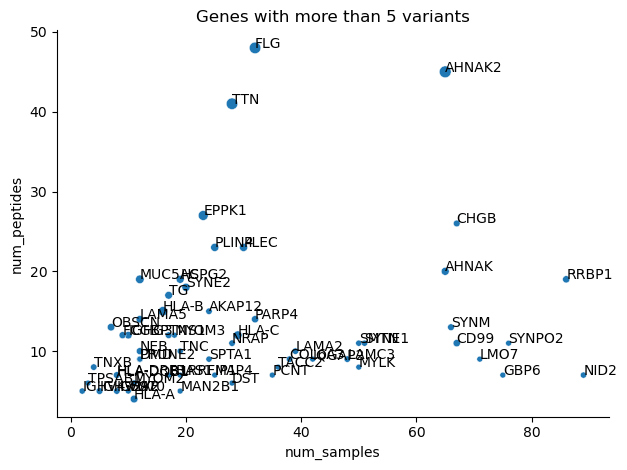

In [80]:
# use the scatterplot function to build the bubble map
genes_df_filtered = genes_df[genes_df.num_vars>5]
plot = sns.scatterplot(
    data=genes_df_filtered,
    x="num_samples",
    y="num_peptides",
    size="num_vars",
    legend=False,
    #sizes=(20, 200)
)
for i,g in enumerate(genes_df_filtered.gene.tolist()):
    plot.annotate(g, (genes_df_filtered.num_samples.tolist()[i], genes_df_filtered.num_peptides.tolist()[i]))
plt.title('Genes with more than 5 variants')
plt.tight_layout()

sns.despine()
plt.savefig('genes_num_vars_peps_samples.pdf')